```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Time Series Forecasting Diagnostics

## Contents

- [Preparing times series data for statistical forecasting](#base)
- Hourly forecast
    - [Load hourly data](#data_h)
    - [Diagnostics](#diag_h)
    - [Modelling](#model_h)
- Daily forecast
    - [Load daily data](#data_d)
    - [Diagnostics](#diag_d)
    - [Modelling](#model_d)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd 
import numpy as np

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from model import (
    get_pm25_data_for_modelling,
    get_best_arima_params_for_time_series,
    get_df_for_lags_columns
)

from measure import (
    get_model_power
)

from plot import (
    plot_observed_vs_predicted,
    plot_observations_to_predictions_relationship,
    fit_theoretical_dist_and_plot,
    plot_ts_corr
)

from stats import (
    adfuller_test
)

---
<a id='base'></a>

## Preparing times series data for statistical forecasting

You need to be aware of the assumptions that are made prior to beginning working with data and statistical modelling in forecasting. The main assumptions are:

- **The previous time step(s) - lag(s) - is useful in predicting the value at the next time step (dependence between values)**. If your time series data values are independent of each other, autoregression isn’t going to be a good forecasting method for that series (`correlation`).
- **Your data is stationary**. A time series is stationary if is mean (and/or variance) is constant over time (over a specified time range). If your time series data isn’t stationary, you’ll need to make it that way with some form of trend and seasonality removal (`decomposition`).

The first is looking at the plot of entire dataset. Then checking the correlation between time series and its lags (autocorrelation).

Looking at the data, it looks pretty stationary. There’s no real trend in the time series but there seems to be something that might be seasonality, so we’ll dig deeper into the data.  Let’s plot a histogram to see what the underlying distribution looks like.

As we can see, the previous time step(s) can be used in predicting the value at the next time step. Our data is also stationary, thus checking statistical models makes sense.

---
<a id='data_h'></a>

## Load hourly data

In [7]:
dfh = get_pm25_data_for_modelling('ts', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 08-Jun-20 17:55:02 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_hourly.hdf
common.py | 43 | get_pm25_data_for_modelling | 08-Jun-20 17:55:02 | INFO: Dataframe size: (96388, 1)


,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


In [8]:
df = dfh.copy()

---
<a id='diag_h'></a>

## Diagnostics

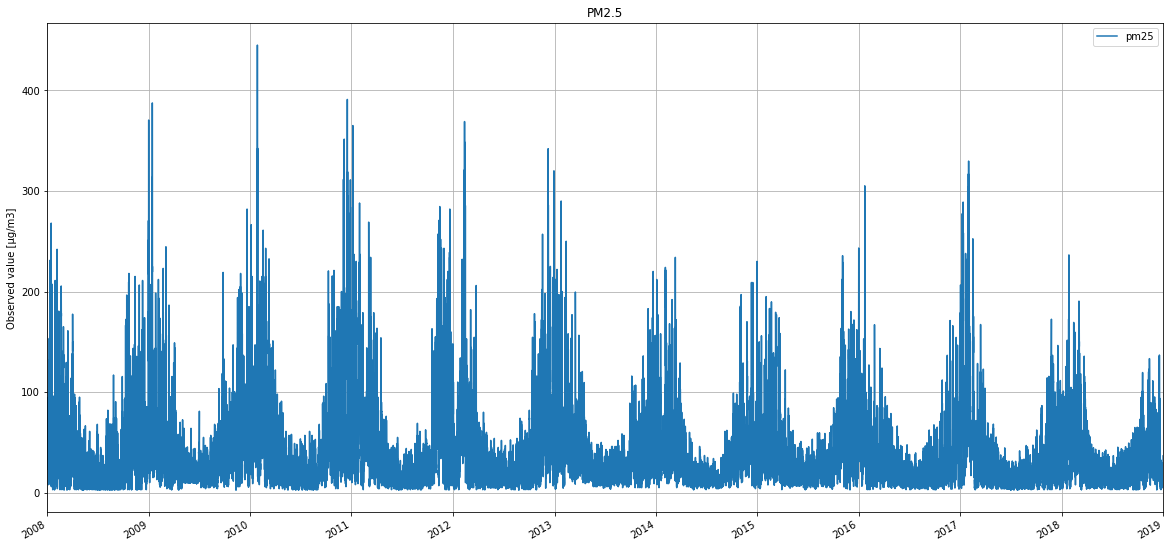

In [9]:
# Plot entire dataset
ax = df.plot(grid=True, figsize=(20, 10), alpha=1)
plt.title('PM2.5')
plt.ylabel('Observed value [µg/m3]')
plt.xlabel('')
plt.savefig('images/pm25_diag_h_data.png')
plt.show();

### Correlation

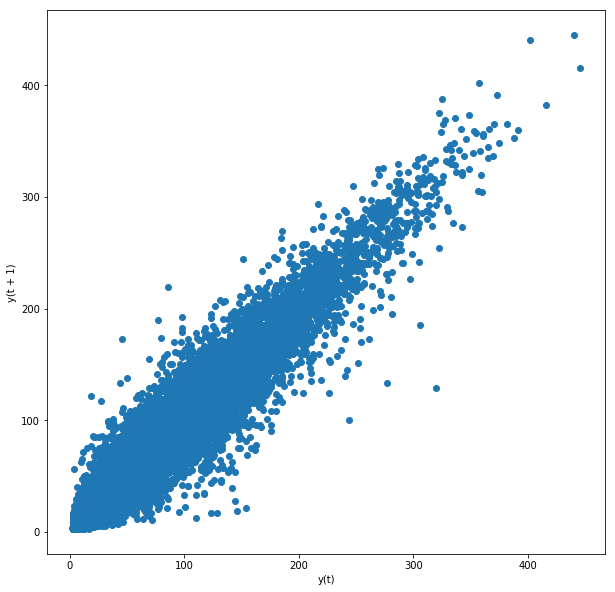

In [10]:
# Plot the time series against its lag1
plt.figure(figsize=(10, 10))
lag_plot(df)
plt.savefig('images/pm25_diag_h_corr_t-1_lag.png')
plt.show();

In [11]:
# Calculate autocorrelation coefficient
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
df1.head()

,t,t-1
Datetime,,
2008-01-01 01:00:00,92.0,NaN
2008-01-01 02:00:00,81.0,92.0
2008-01-01 03:00:00,73.0,81.0
2008-01-01 04:00:00,60.5,73.0
2008-01-01 05:00:00,61.0,60.5


In [12]:
df1.corr(method='pearson')

,t,t-1
t,1.000000,0.972629
t-1,0.972629,1.000000


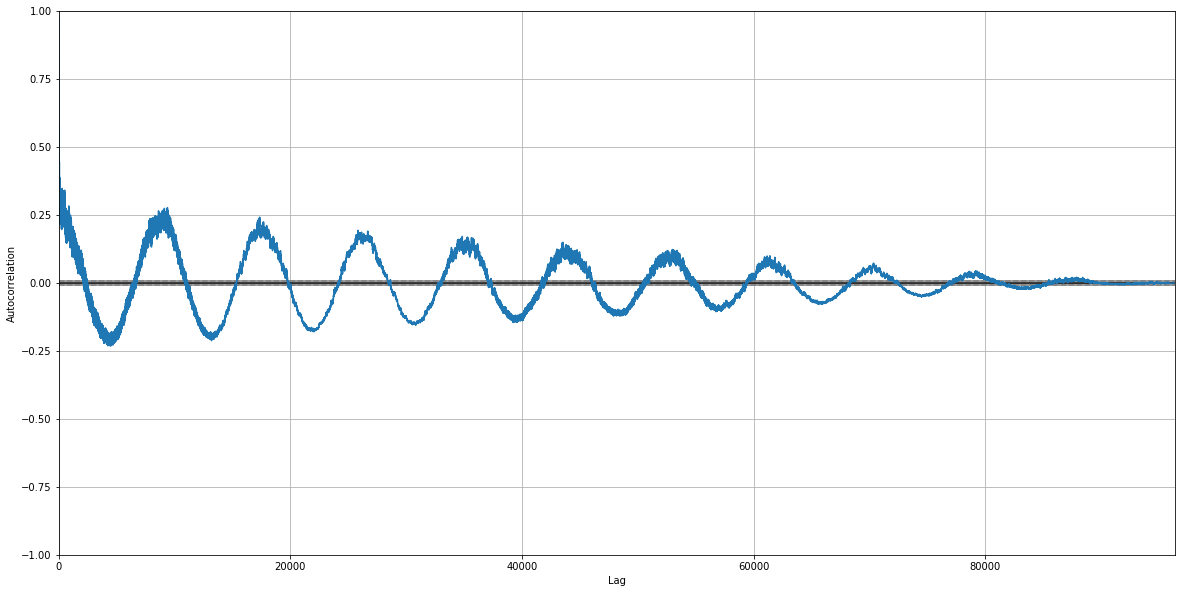

In [13]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(20, 10))
autocorrelation_plot(df)
plt.savefig('images/pm25_diag_h_corr_auto1.png')
plt.show();

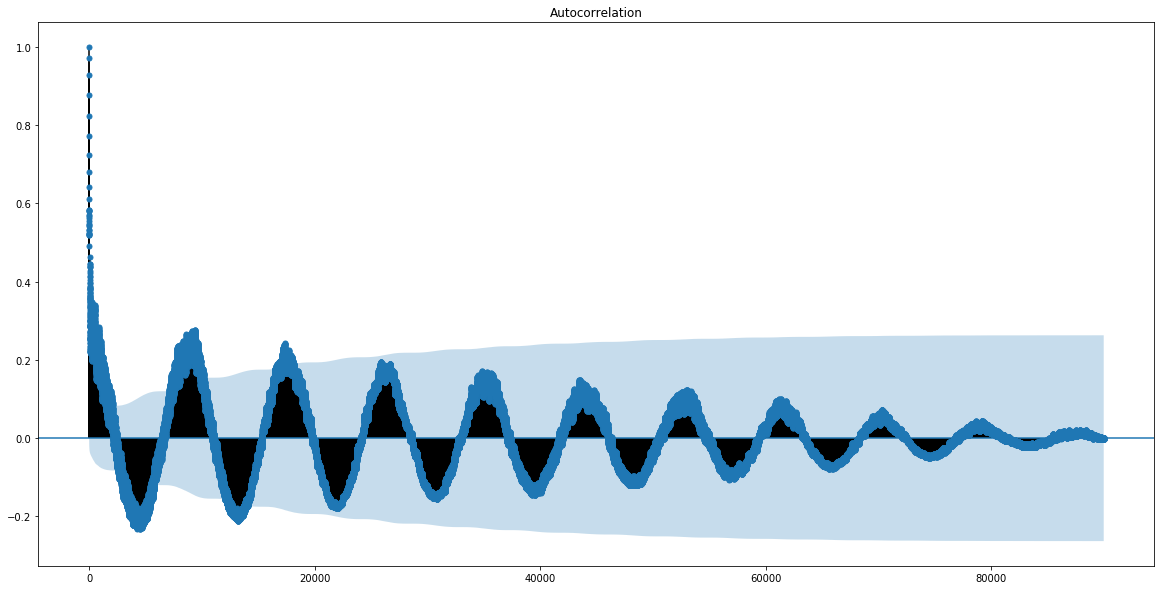

In [14]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=90000)
plt.savefig('images/pm25_diag_h_corr_auto2.png')
plt.show();

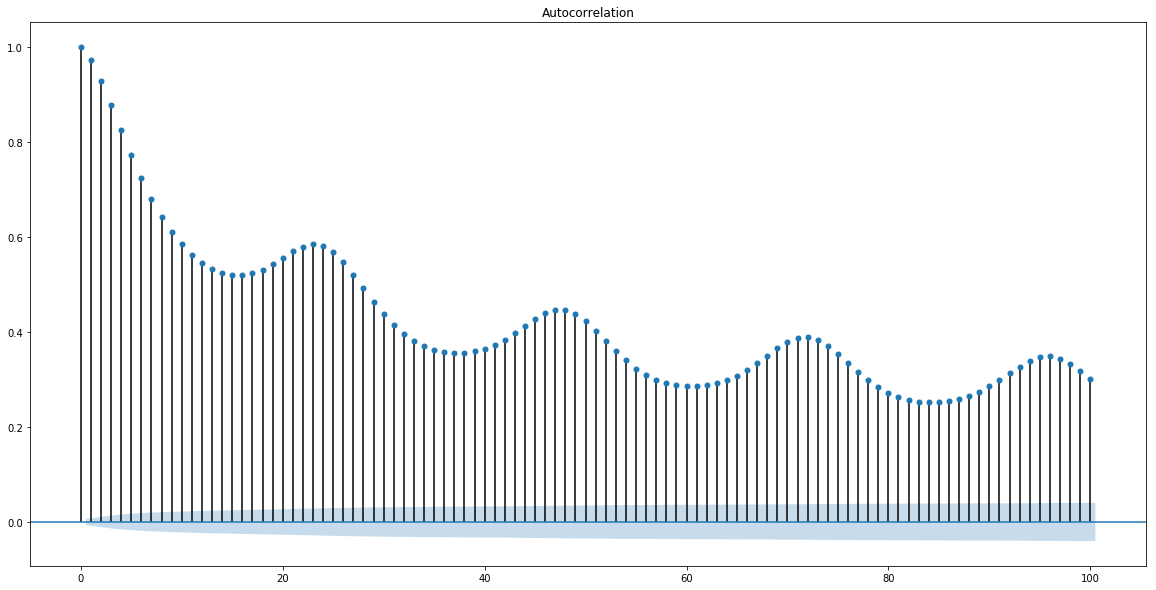

In [15]:
# Plot the AutoCorrelation Function, using candle sticks (zoom to first lags)
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=100)
plt.savefig('images/pm25_diag_h_corr_auto3.png')
plt.show();

In [16]:
df1 = get_df_for_lags_columns(data=df, col_name='pm25', n_lags=10, remove_nans=True)
df1

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,
2008-01-01 11:00:00,30.5000,41.5000,62.5000,70.5000,69.5000,67.0000,61.0000,60.5000,73.00000,81.00000,92.00000
2008-01-01 12:00:00,26.0000,30.5000,41.5000,62.5000,70.5000,69.5000,67.0000,61.0000,60.50000,73.00000,81.00000
2008-01-01 13:00:00,28.5000,26.0000,30.5000,41.5000,62.5000,70.5000,69.5000,67.0000,61.00000,60.50000,73.00000
2008-01-01 14:00:00,28.0000,28.5000,26.0000,30.5000,41.5000,62.5000,70.5000,69.5000,67.00000,61.00000,60.50000
2008-01-01 15:00:00,32.5000,28.0000,28.5000,26.0000,30.5000,41.5000,62.5000,70.5000,69.50000,67.00000,61.00000
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,23.6990,19.3182,18.8965,19.4075,9.7000,9.9000,11.8866,7.0000,9.01751,6.94473,7.02653
2018-12-31 21:00:00,32.6308,23.6990,19.3182,18.8965,19.4075,9.7000,9.9000,11.8866,7.00000,9.01751,6.94473
2018-12-31 22:00:00,31.0801,32.6308,23.6990,19.3182,18.8965,19.4075,9.7000,9.9000,11.88660,7.00000,9.01751


In [17]:
corr = df1.corr(method='pearson')
corr

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.000000,0.972630,0.928895,0.878067,0.824614,0.772477,0.723828,0.680733,0.642858,0.610756,0.584242
t-1,0.972630,1.000000,0.972629,0.928893,0.878064,0.824613,0.772477,0.723828,0.680732,0.642857,0.610753
t-2,0.928895,0.972629,1.000000,0.972629,0.928893,0.878065,0.824614,0.772478,0.723830,0.680734,0.642859
t-3,0.878067,0.928893,0.972629,1.000000,0.972629,0.928893,0.878066,0.824615,0.772480,0.723833,0.680738
t-4,0.824614,0.878064,0.928893,0.972629,1.000000,0.972629,0.928894,0.878067,0.824617,0.772483,0.723836
t-5,0.772477,0.824613,0.878065,0.928893,0.972629,1.000000,0.972629,0.928894,0.878068,0.824618,0.772484
t-6,0.723828,0.772477,0.824614,0.878066,0.928894,0.972629,1.000000,0.972629,0.928894,0.878067,0.824617
t-7,0.680733,0.723828,0.772478,0.824615,0.878067,0.928894,0.972629,1.000000,0.972629,0.928893,0.878065
t-8,0.642858,0.680732,0.723830,0.772480,0.824617,0.878068,0.928894,0.972629,1.000000,0.972629,0.928893
t-9,0.610756,0.642857,0.680734,0.723833,0.772483,0.824618,0.878067,0.928893,0.972629,1.000000,0.972629


In [18]:
corr[0:1]

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.0,0.97263,0.928895,0.878067,0.824614,0.772477,0.723828,0.680733,0.642858,0.610756,0.584242


What we can see here is yearly and daily sesonal cycles and the most influencing (autocorrelated) hourly lags being closer to the observation point at lag 0. The first 6 lagged values are highly correlated to the times series (correlation coefficient higher than 0.7), and this correlation is statistifically significant. After lag 6, we observe steady decline of correlation.

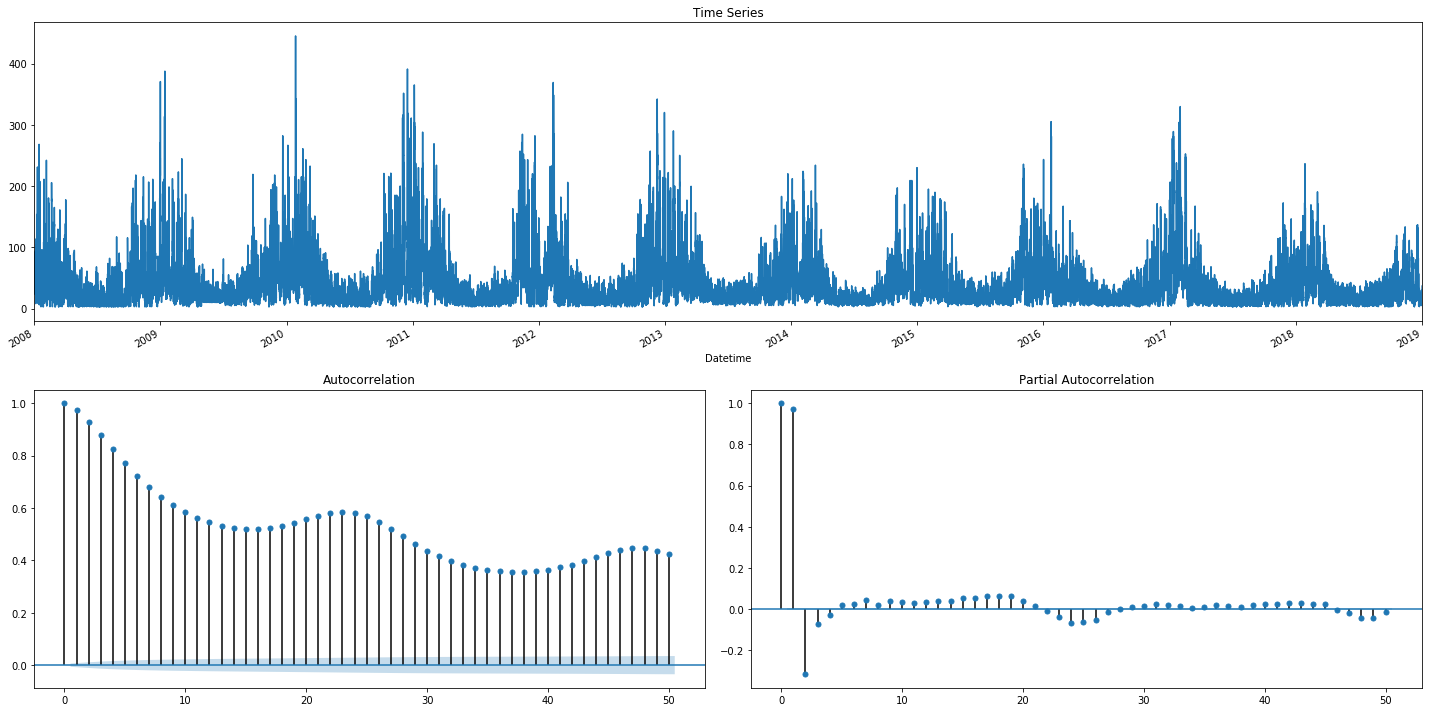

In [19]:
plot_ts_corr(df['pm25'])
plt.savefig('images/pm25_diag_h_corr_acf_pacf.png')

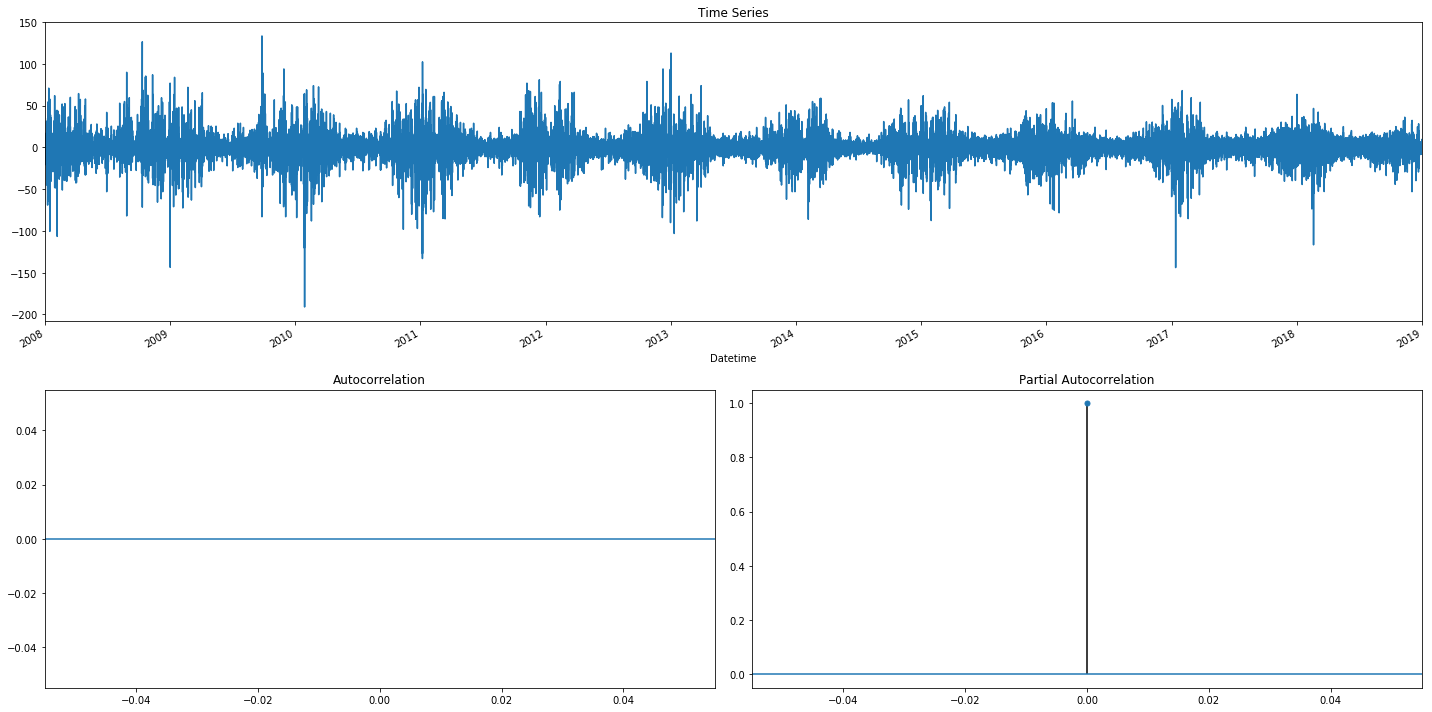

In [20]:
df1 = df.diff()
plot_ts_corr(df1['pm25'])
plt.savefig('images/pm25_diag_h_corr_acf_pacf_diff1.png')

### Stationarity

You can use is to look at the mean and variance of multiple sections of the data and compare them. If they are similar, your data is most likely stationary.

In [21]:
one, two, three, four, five = np.split(df.sample(frac=1), [int(.20*len(df)), int(.35*len(df)), int(.60*len(df)), int(.70*len(df))])

In [22]:
one.shape, two.shape, three.shape, four.shape, five.shape

((19277, 1), (14458, 1), (24097, 1), (9639, 1), (28917, 1))

If the data is stationary, the means/variances should be similar.

In [23]:
mean1, mean2, mean3, mean4, mean5 = one.mean(), two.mean(), three.mean(), four.mean(), five.mean()
var1, var2, var3, var4, var5 = one.var(), two.var(), three.var(), four.var(), five.var()

print(f'Means: {mean1}, {mean2}, {mean3}, {mean4}, {mean5}')
print(f'Variances: {var1}, {var2}, {var3}, {var4}, {var5}')

Means: pm25    36.887162
dtype: float64, pm25    37.044273
dtype: float64, pm25    36.911525
dtype: float64, pm25    37.680054
dtype: float64, pm25    37.553932
dtype: float64
Variances: pm25    1488.630086
dtype: float64, pm25    1419.002341
dtype: float64, pm25    1456.034909
dtype: float64, pm25    1548.392072
dtype: float64, pm25    1536.316199
dtype: float64


The means and variances are similar, pointing to stationary data. Let's confirm it with the statistical test

In [24]:
adfuller_test(df)

Test statistic: -18.348339980165512
P-value: 2.2390596215367323e-30 -> 0.0000000000000000
Critical values: {'1%': -3.4304178932130585, '5%': -2.8615700077238575, '10%': -2.5667859720635713}
The time series does not have a unit root, so it is stationary (reject H0)


Our p-value is definitely less than 0.05 and is even less than 0.01 so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary. Additionally, our ADF test statistic is much less than our 1% confidence value of -3.43, so we have another confirmation that we can reject the null.

A time series can be made stationary by removing/reducing trend and seasonality - see Time Series Decomposition notebook for details.

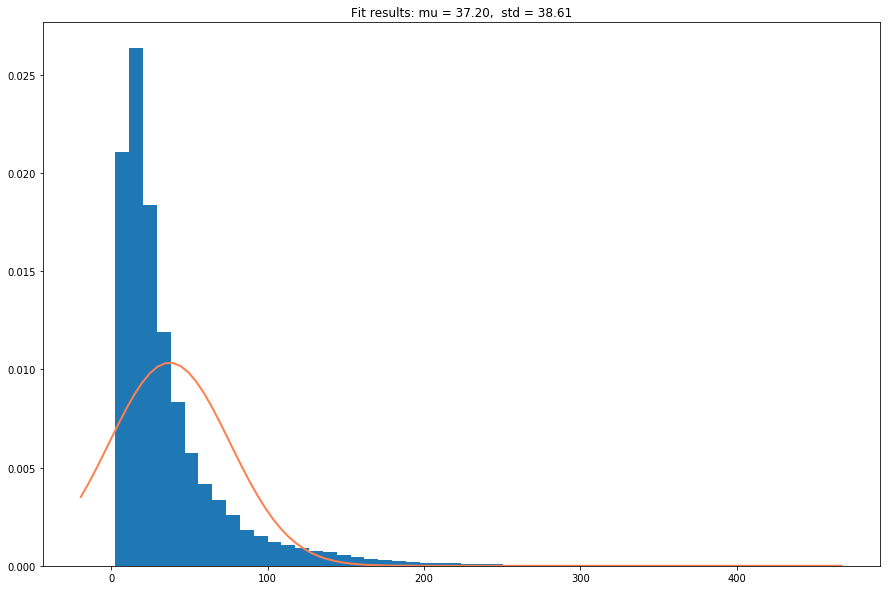

In [25]:
# Fit theoretical distribution
fit_theoretical_dist_and_plot(df['pm25'].values)

Does not look Gaussian with a bit of a long tail skew toward the right. We see that the shape is not ‘bell-shaped’ most likely due to trending and/or seasonality (we see more data plotted to the right).

---
<a id='data_d'></a>

## Load daily data

In [26]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 08-Jun-20 17:55:42 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 08-Jun-20 17:55:42 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [27]:
df = dfd.copy()

---
<a id='diag_d'></a>

## Diagnostics

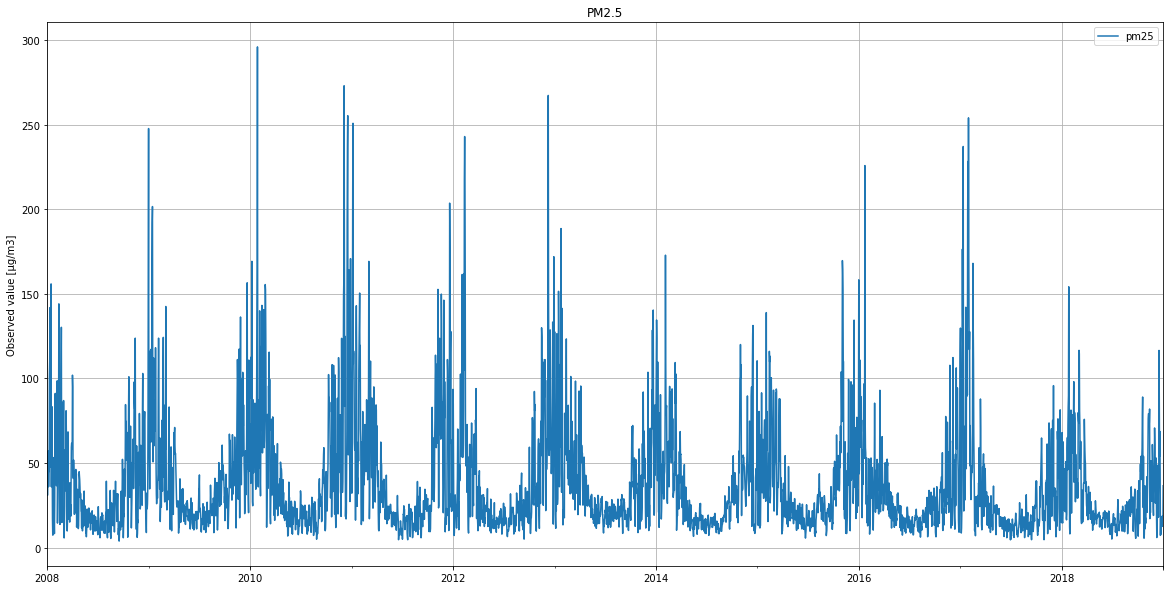

In [28]:
# Plot entire dataset
ax = df.plot(grid=True, figsize=(20, 10), alpha=1)
plt.title('PM2.5')
plt.ylabel('Observed value [µg/m3]')
plt.xlabel('')
plt.savefig('images/pm25_diag_d_data.png')
plt.show();

### Correlation

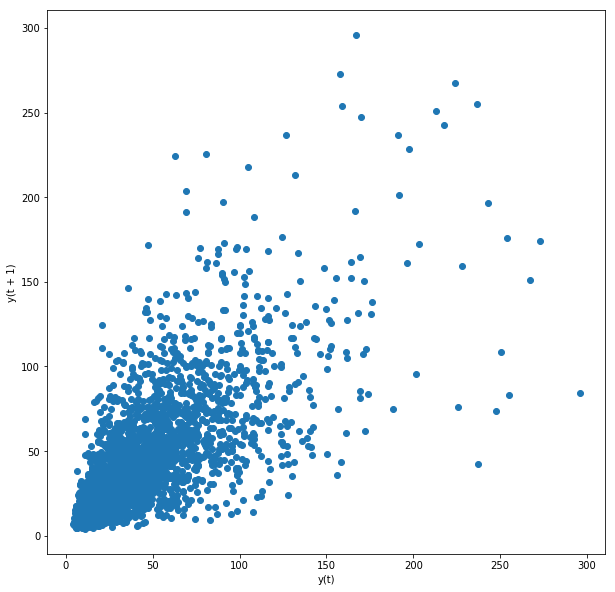

In [29]:
# Plot the time series against its lag1
plt.figure(figsize=(10, 10))
lag_plot(df)
plt.savefig('images/pm25_diag_d_corr_t-1_lag.png')
plt.show();

In [30]:
# Calculate autocorrelation coefficient
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
df1.head()

,t,t-1
Datetime,,
2008-01-01,53.586957,NaN
2008-01-02,30.958333,53.586957
2008-01-03,46.104167,30.958333
2008-01-04,42.979167,46.104167
2008-01-05,57.312500,42.979167


In [31]:
df1.corr(method='pearson')

,t,t-1
t,1.000000,0.740933
t-1,0.740933,1.000000


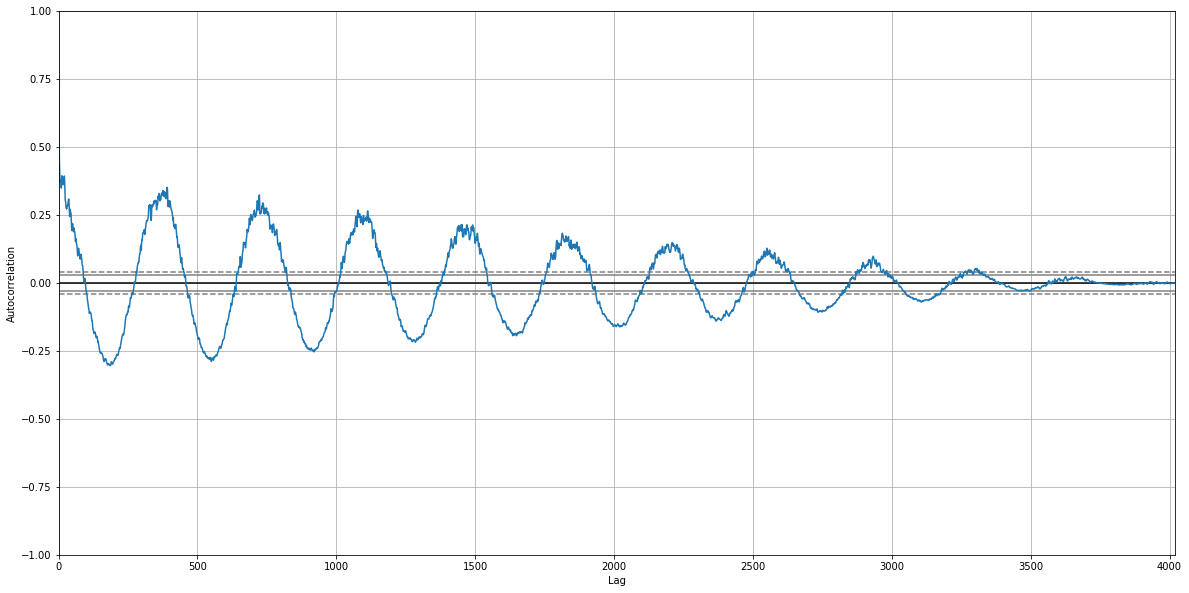

In [32]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(20, 10))
autocorrelation_plot(df)
plt.savefig('images/pm25_diag_d_corr_auto1.png')
plt.show();

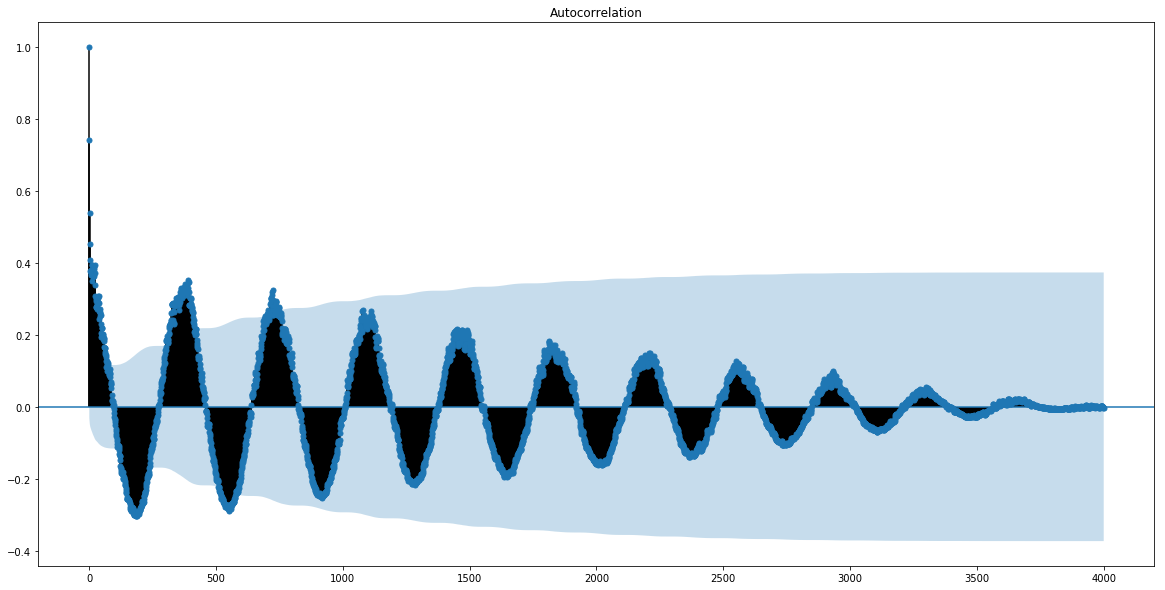

In [33]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=4000)
plt.savefig('images/pm25_diag_d_corr_auto2.png')
plt.show();

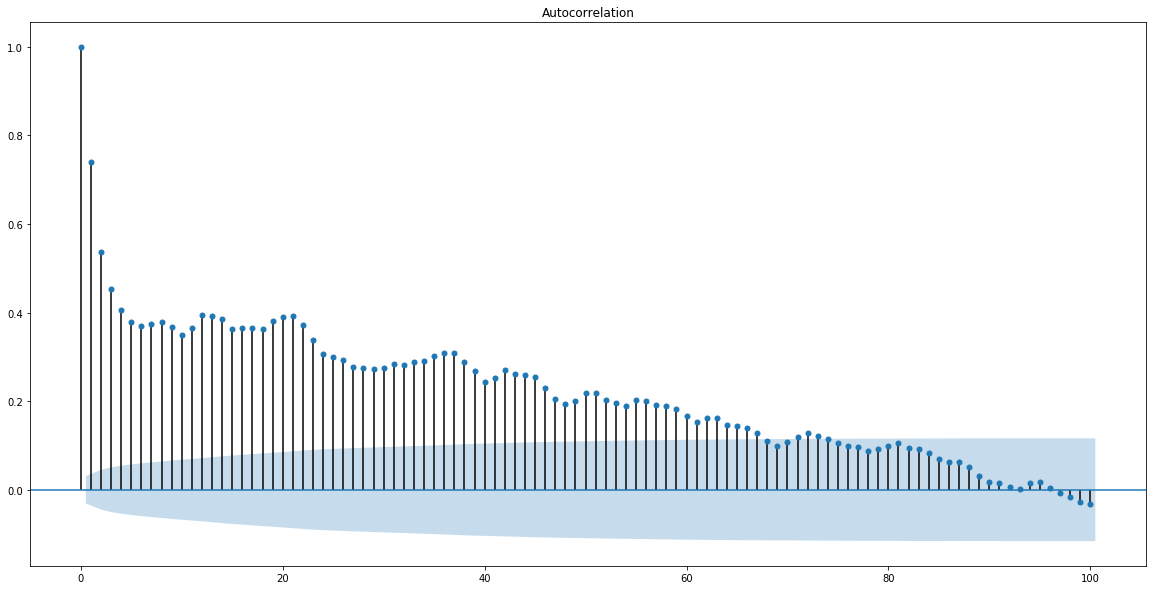

In [34]:
# Plot the AutoCorrelation Function, using candle sticks (zoom to first lags)
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=100)
plt.savefig('images/pm25_diag_d_corr_auto3.png')
plt.show();

In [35]:
df1 = get_df_for_lags_columns(data=df, col_name='pm25', n_lags=10, remove_nans=True)
df1

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,
2008-01-11,141.833333,110.083333,101.375000,45.041667,46.083333,36.062500,57.312500,42.979167,46.104167,30.958333,53.586957
2008-01-12,47.625000,141.833333,110.083333,101.375000,45.041667,46.083333,36.062500,57.312500,42.979167,46.104167,30.958333
2008-01-13,76.270833,47.625000,141.833333,110.083333,101.375000,45.041667,46.083333,36.062500,57.312500,42.979167,46.104167
2008-01-14,96.687500,76.270833,47.625000,141.833333,110.083333,101.375000,45.041667,46.083333,36.062500,57.312500,42.979167
2008-01-15,155.854167,96.687500,76.270833,47.625000,141.833333,110.083333,101.375000,45.041667,46.083333,36.062500,57.312500
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-28,18.614863,15.274438,17.102352,15.821442,8.041177,17.058399,7.282959,44.248342,68.650688,54.046512,88.693562
2018-12-29,16.241051,18.614863,15.274438,17.102352,15.821442,8.041177,17.058399,7.282959,44.248342,68.650688,54.046512
2018-12-30,15.514396,16.241051,18.614863,15.274438,17.102352,15.821442,8.041177,17.058399,7.282959,44.248342,68.650688


In [36]:
corr = df1.corr(method='pearson')
corr

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.000000,0.741031,0.537639,0.453171,0.406745,0.378566,0.370809,0.375167,0.379451,0.367351,0.349834
t-1,0.741031,1.000000,0.741364,0.537458,0.453054,0.406481,0.378677,0.370687,0.375098,0.379134,0.367406
t-2,0.537639,0.741364,1.000000,0.741082,0.537269,0.452756,0.406493,0.378505,0.370559,0.374709,0.379113
t-3,0.453171,0.537458,0.741082,1.000000,0.741058,0.537218,0.452707,0.406437,0.378446,0.370450,0.374660
t-4,0.406745,0.453054,0.537269,0.741058,1.000000,0.741025,0.537179,0.452658,0.406385,0.378340,0.370406
t-5,0.378566,0.406481,0.452756,0.537218,0.741025,1.000000,0.740959,0.537134,0.452599,0.406313,0.378267
t-6,0.370809,0.378677,0.406493,0.452707,0.537179,0.740959,1.000000,0.740921,0.537094,0.452464,0.406297
t-7,0.375167,0.370687,0.378505,0.406437,0.452658,0.537134,0.740921,1.000000,0.740897,0.537021,0.452418
t-8,0.379451,0.375098,0.370559,0.378446,0.406385,0.452599,0.537094,0.740897,1.000000,0.740840,0.536986
t-9,0.367351,0.379134,0.374709,0.370450,0.378340,0.406313,0.452464,0.537021,0.740840,1.000000,0.740759


In [37]:
corr[0:1]

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
t,1.0,0.741031,0.537639,0.453171,0.406745,0.378566,0.370809,0.375167,0.379451,0.367351,0.349834


What we can see here is yearly sesonal cycles and the most influencing (autocorrelated) daily lags being closer to the observation point at lag 0. The first lagged value is highly correlated to the times series (correlation coefficient higher than 0.7), and this correlation is statistifically significant. For this dataset we will consider two more lags for the modelling (t-2 and t-3). After lag 3, we observe steady decline of correlation.

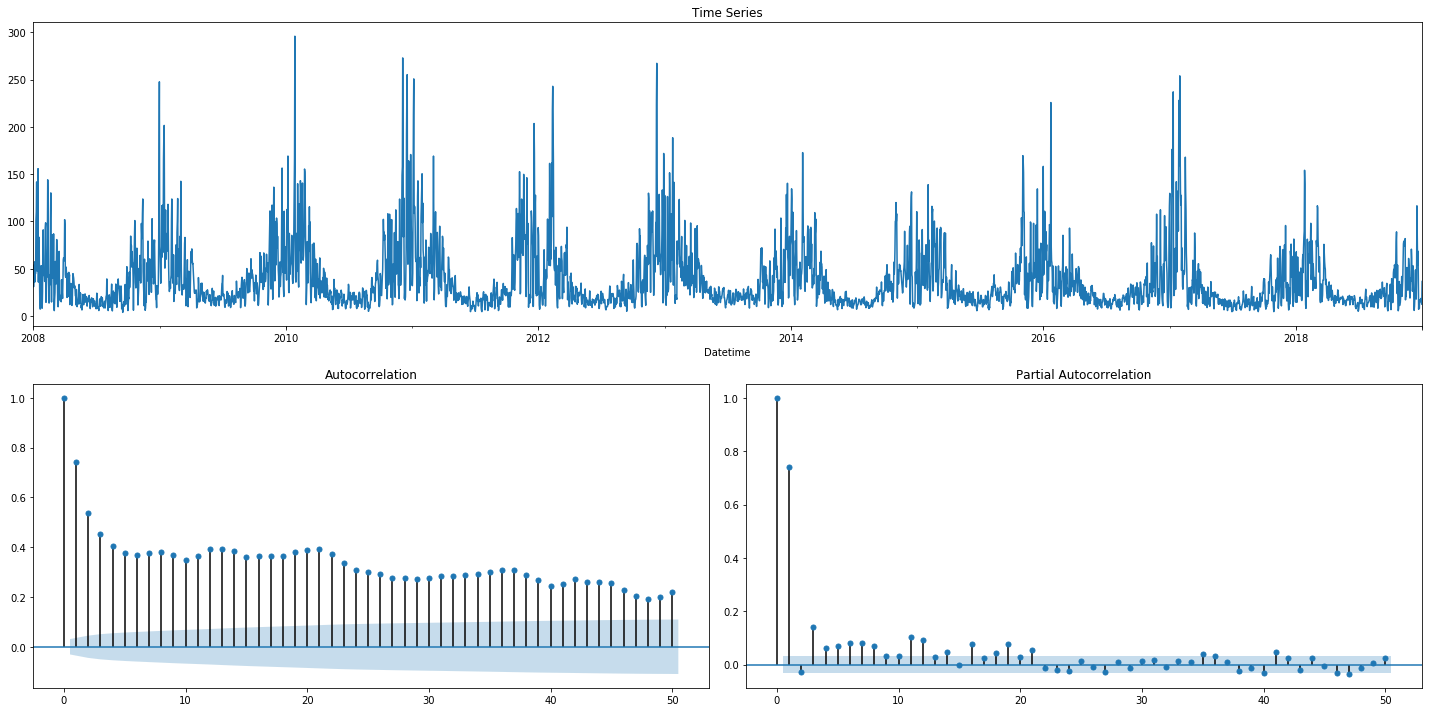

In [38]:
plot_ts_corr(df['pm25'])
plt.savefig('images/pm25_diag_d_corr_acf_pacf.png')

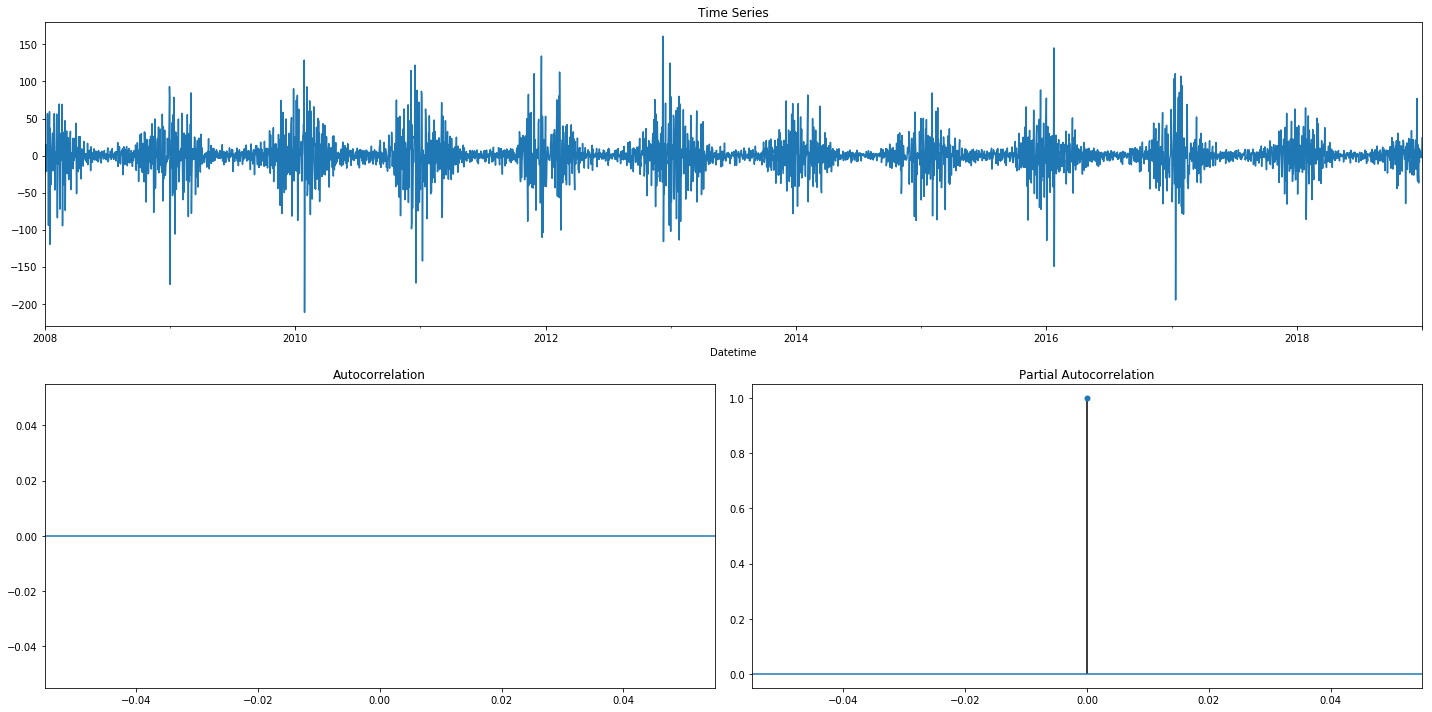

In [39]:
df1 = df.diff()
plot_ts_corr(df1['pm25'])
plt.savefig('images/pm25_diag_d_corr_acf_pacf_diff1.png')

### Stationarity

In [40]:
one, two, three, four, five = np.split(df.sample(frac=1), 
                                       [int(.20*len(df)), 
                                        int(.35*len(df)), 
                                        int(.60*len(df)), 
                                        int(.70*len(df))])

In [41]:
one.shape, two.shape, three.shape, four.shape, five.shape

((803, 1), (603, 1), (1005, 1), (402, 1), (1206, 1))

In [42]:
mean1, mean2, mean3, mean4, mean5 = one.mean(), two.mean(), three.mean(), four.mean(), five.mean()
var1, var2, var3, var4, var5 = one.var(), two.var(), three.var(), four.var(), five.var()

print(f'Means: {mean1}, {mean2}, {mean3}, {mean4}, {mean5}')
print(f'Variances: {var1}, {var2}, {var3}, {var4}, {var5}')

Means: pm25    37.562642
dtype: float64, pm25    36.877904
dtype: float64, pm25    35.881121
dtype: float64, pm25    38.220752
dtype: float64, pm25    37.868112
dtype: float64
Variances: pm25    1125.598154
dtype: float64, pm25    974.263874
dtype: float64, pm25    918.376818
dtype: float64, pm25    1081.451883
dtype: float64, pm25    1115.161713
dtype: float64


In [43]:
adfuller_test(df)

Test statistic: -5.366998980124506
P-value: 3.9719053421998694e-06 -> 0.0000039719053422
Critical values: {'1%': -3.431986694239327, '5%': -2.8622632019846224, '10%': -2.567154968134392}
The time series does not have a unit root, so it is stationary (reject H0)


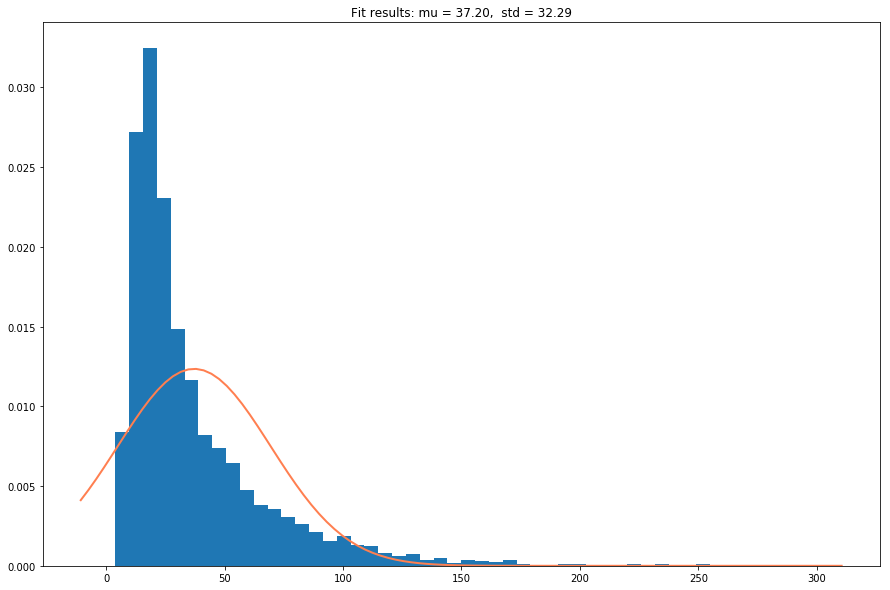

In [44]:
# Fit theoretical distribution
fit_theoretical_dist_and_plot(df['pm25'].values)